In [2]:
import pandas as pd
import numpy as np
import json

from geopy.geocoders import Nominatim # to conver address to lat and long values

import requests # handle requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # JSON to pandas dataframe

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium # for maps

## Scraping data from Wikipedia

In [3]:
data = requests.get('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai').text

In [4]:
soup = BeautifulSoup(data, 'html.parser') # BeautifulSoup object to parse data
area = []
location = []
latitudes = []
longitudes = []

In [5]:
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0): # condition because some rows may be empty && first row is header
        area.append(cells[0].text.rstrip('\n'))
        location.append(cells[1].text.rstrip('\n'))
        latitudes.append(cells[2].text.rstrip('\n'))
        longitudes.append(cells[3].text.rstrip('\n'))

In [6]:
mumbai_df = pd.DataFrame({'Area': area,
                           'Location': location,
                           'Latitude': latitudes,
                           'Longitude': longitudes})
print(mumbai_df.shape)
mumbai_df.head()


(93, 4)


,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.1293,72.8434
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.82721
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.82927


In [7]:
# mumbai_df['Area'].value_counts().tolist()

In [39]:
len(mumbai_df['Location'].unique())

31

## Use geopy to get coordinates of Mumbai

In [8]:
address = 'Mumbai'
geolocator = Nominatim(user_agent = 'lol-app') # for the purpose of assignment; give any name to user_agent
location= geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("Mumbai coordinates : {}, {}".format(latitude, longitude))

Mumbai coordinates : 19.0759899, 72.8773928


## Create a map of Mumbai

In [9]:
map_mumbai = folium.Map(location = [latitude, longitude], zoom_start = 10.3) #creates map
#add markers to map

for lat, long, area, location in zip(mumbai_df['Latitude'], mumbai_df['Longitude'], mumbai_df['Area'], mumbai_df['Location']):
    label = '{}, {}'.format(area, location)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, long],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity=0.7
    ).add_to(map_mumbai)
    
map_mumbai

## Now, to use the FourSquare API to explore neighborhoods

In [76]:
CLIENT_ID = 'your_client_id'
CLIENT_SECRET = 'your_client_secret'
VERSION = '20180604'

## Getting top 50 venues that are within a radius of 250 mts

In [13]:
radius = 250
LIMIT = 50

venues = []

for lat, long, area, location in zip(mumbai_df['Latitude'], mumbai_df['Longitude'], mumbai_df['Area'], mumbai_df['Location']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            area, 
            location,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [14]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

venues_df.head()

,0,1,2,3,4,5,6,7
0,Amboli,"Andheri,Western Suburbs",19.1293,72.8434,Subway,19.127860,72.844461,Sandwich Place
1,Amboli,"Andheri,Western Suburbs",19.1293,72.8434,Cafe Coffee Day,19.127748,72.844663,Coffee Shop
2,Amboli,"Andheri,Western Suburbs",19.1293,72.8434,Spices & Chillies,19.127765,72.844131,Asian Restaurant
3,Amboli,"Andheri,Western Suburbs",19.1293,72.8434,V33,19.129068,72.843670,Gym
4,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,Cafe Coffee Day,19.112272,72.861106,Café


In [15]:
venues_df.columns = ['Area', 'Location', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
print(venues_df.shape)
venues_df.head()

(495, 8)


,Area,Location,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Amboli,"Andheri,Western Suburbs",19.1293,72.8434,Subway,19.127860,72.844461,Sandwich Place
1,Amboli,"Andheri,Western Suburbs",19.1293,72.8434,Cafe Coffee Day,19.127748,72.844663,Coffee Shop
2,Amboli,"Andheri,Western Suburbs",19.1293,72.8434,Spices & Chillies,19.127765,72.844131,Asian Restaurant
3,Amboli,"Andheri,Western Suburbs",19.1293,72.8434,V33,19.129068,72.843670,Gym
4,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,Cafe Coffee Day,19.112272,72.861106,Café


In [16]:
# venues_df.groupby(['Area', 'Location']).count()

In [17]:
print("count of unique venue categories : {}".format(len(venues_df["VenueCategory"].unique())))

count of unique venue categories : 120


## Analysing Each Area

In [25]:
# one hot encoding
mumbai_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
mumbai_onehot['Area'] = venues_df['Area'] 
mumbai_onehot['Location'] = venues_df['Location']

fixed_columns = list(mumbai_onehot.columns[-2:]) + list(mumbai_onehot.columns[:-2])
mumbai_onehot = mumbai_onehot[fixed_columns]

print(mumbai_onehot.shape)
mumbai_onehot

(495, 122)


,Area,Location,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,...,Sports Bar,Steakhouse,Tea Room,Theater,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Women's Store
0,Amboli,"Andheri,Western Suburbs",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Amboli,"Andheri,Western Suburbs",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Amboli,"Andheri,Western Suburbs",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Amboli,"Andheri,Western Suburbs",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Chakala, Andheri",Western Suburbs,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,Dava Bazaar,South Mumbai,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
491,Dava Bazaar,South Mumbai,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
492,Dava Bazaar,South Mumbai,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493,Dava Bazaar,South Mumbai,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Now to group this data by Area and take the mean of occurence of each category in that neighborhood

In [29]:
## Locations grouped by area first
mumbai_grouped_area = mumbai_onehot.groupby(['Area', "Location"]).mean().reset_index()

print(mumbai_grouped_area.shape)
mumbai_grouped_area

(77, 122)


,Area,Location,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,...,Sports Bar,Steakhouse,Tea Room,Theater,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Women's Store
0,Altamount Road,South Mumbai,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Amboli,"Andheri,Western Suburbs",0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Amrut Nagar,"Ghatkopar,Eastern Suburbs",0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Asalfa,"Ghatkopar,Eastern Suburbs",0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ballard Estate,"Fort,South Mumbai",0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Uttan,"Mira-Bhayandar,Western Suburbs",0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,Vidyavihar,Eastern Suburbs,0.0,0.0,0.0,0.00,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,Vile Parle,Western Suburbs,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75,Walkeshwar,South Mumbai,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# mumbai_grouped_area['Area'].value_counts().tolist()

#### when grouped by area this dataset has only 77 rows while the original dataset had 93 rows indicating that data on some of the areas is missing. So we drop those rows for our experiment in mumbai_df

In [31]:
valid_areas = mumbai_grouped_area['Area'].tolist()
#valid_areas

In [32]:
mumbai_df_final = mumbai_df[mumbai_df['Area'].isin(valid_areas)]
mumbai_df_final.shape

(77, 4)

## Top 10 venues by category for each Area

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['Area', 'Location']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
area_venues_sorted = pd.DataFrame(columns=columns)
area_venues_sorted['Area'] = mumbai_grouped_area['Area']
area_venues_sorted['Location'] = mumbai_grouped_area['Location']

for ind in np.arange(mumbai_grouped_area.shape[0]):
    row_categories = mumbai_grouped_area.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    area_venues_sorted.iloc[ind, 2:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(area_venues_sorted.shape)
area_venues_sorted

(77, 12)


,Area,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altamount Road,South Mumbai,Café,Women's Store,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store,Farmers Market
1,Amboli,"Andheri,Western Suburbs",Asian Restaurant,Coffee Shop,Gym,Sandwich Place,Women's Store,French Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner
2,Amrut Nagar,"Ghatkopar,Eastern Suburbs",Shopping Mall,Women's Store,Fried Chicken Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store,Farmers Market
3,Asalfa,"Ghatkopar,Eastern Suburbs",Playground,Light Rail Station,French Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store
4,Ballard Estate,"Fort,South Mumbai",Harbor / Marina,Convenience Store,Hotel,French Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store
...,...,...,...,...,...,...,...,...,...,...,...,...
72,Uttan,"Mira-Bhayandar,Western Suburbs",Indian Restaurant,Juice Bar,Resort,Bus Station,Fried Chicken Joint,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store
73,Vidyavihar,Eastern Suburbs,Restaurant,Athletics & Sports,Fast Food Restaurant,Bus Station,Women's Store,Fried Chicken Joint,Deli / Bodega,Department Store,Dessert Shop,Diner
74,Vile Parle,Western Suburbs,Turkish Restaurant,Women's Store,Fried Chicken Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store,Farmers Market
75,Walkeshwar,South Mumbai,Ice Cream Shop,Lighthouse,Coffee Shop,Indian Restaurant,Harbor / Marina,Food Truck,Dance Studio,Deli / Bodega,Hotel Bar,Department Store


### Locations grouped by area is not very insightful... so let's group the data by location.

In [35]:
mumbai_grouped_location = mumbai_onehot.groupby(['Location']).mean().reset_index()

print(mumbai_grouped_location.shape)
mumbai_grouped_location

(24, 121)


,Location,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Bakery,...,Sports Bar,Steakhouse,Tea Room,Theater,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Women's Store
0,"Andheri,Western Suburbs",0.000000,0.000000,0.000000,0.052632,0.000000,0.026316,0.0000,0.000000,0.026316,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
1,"Antop Hill,South Mumbai",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,"Bandra,Western Suburbs",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.078947,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.026316,0.000000,0.000000,0.026316
3,"Borivali (West),Western Suburbs",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
4,Eastern Suburbs,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.0000,0.000000,0.000000,...,0.076923,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
5,"Fort,South Mumbai",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
6,"Ghatkopar,Eastern Suburbs",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
7,"Govandi,Harbour Suburbs",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
8,Harbour Suburbs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.200000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
9,"Kalbadevi,South Mumbai",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


## Top 10 venues by category for each Location


In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['Location']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
location_venues_sorted = pd.DataFrame(columns=columns)
location_venues_sorted['Location'] = mumbai_grouped_location['Location']

for ind in np.arange(mumbai_grouped_location.shape[0]):
    row_categories = mumbai_grouped_location.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    location_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(location_venues_sorted.shape)
location_venues_sorted

(24, 11)


,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Andheri,Western Suburbs",Café,Ice Cream Shop,Indian Restaurant,Chinese Restaurant,Bar,Asian Restaurant,Seafood Restaurant,Smoke Shop,Pub,Restaurant
1,"Antop Hill,South Mumbai",Café,Ice Cream Shop,Burrito Place,Liquor Store,Cajun / Creole Restaurant,Garden Center,Department Store,Dessert Shop,Diner,Electronics Store
2,"Bandra,Western Suburbs",Indian Restaurant,Bakery,Clothing Store,Café,Fast Food Restaurant,Gourmet Shop,Chinese Restaurant,Snack Place,Cocktail Bar,Lounge
3,"Borivali (West),Western Suburbs",Bar,Ice Cream Shop,Seafood Restaurant,Indian Restaurant,Dessert Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Diner,Electronics Store
4,Eastern Suburbs,Restaurant,Multiplex,Indian Restaurant,Fast Food Restaurant,Fried Chicken Joint,Café,Shopping Mall,Sports Bar,Athletics & Sports,Hotel
5,"Fort,South Mumbai",Harbor / Marina,Convenience Store,Hotel,Women's Store,Fried Chicken Joint,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store
6,"Ghatkopar,Eastern Suburbs",Indian Restaurant,Snack Place,Ice Cream Shop,Italian Restaurant,Multiplex,Playground,Light Rail Station,Shopping Mall,Women's Store,Food
7,"Govandi,Harbour Suburbs",Paper / Office Supplies Store,Pool,Smoke Shop,Snack Place,Bar,Women's Store,Farmers Market,Food & Drink Shop,Food,Fast Food Restaurant
8,Harbour Suburbs,Indian Restaurant,Diner,Sports Bar,General Entertainment,Gastropub,French Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
9,"Kalbadevi,South Mumbai",Fast Food Restaurant,Bus Station,Sandwich Place,Women's Store,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store


# K- means clustering


## 1) on data grouped by area


In [42]:
mumbai_grouped_clustering = mumbai_grouped_area.drop(['Area', 'Location'], 1)
mumbai_grouped_clustering

,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Bakery,Bank,...,Sports Bar,Steakhouse,Tea Room,Theater,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Women's Store
0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,0.0,0.0,0.0,0.00,0.2,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Finding Ideal k value


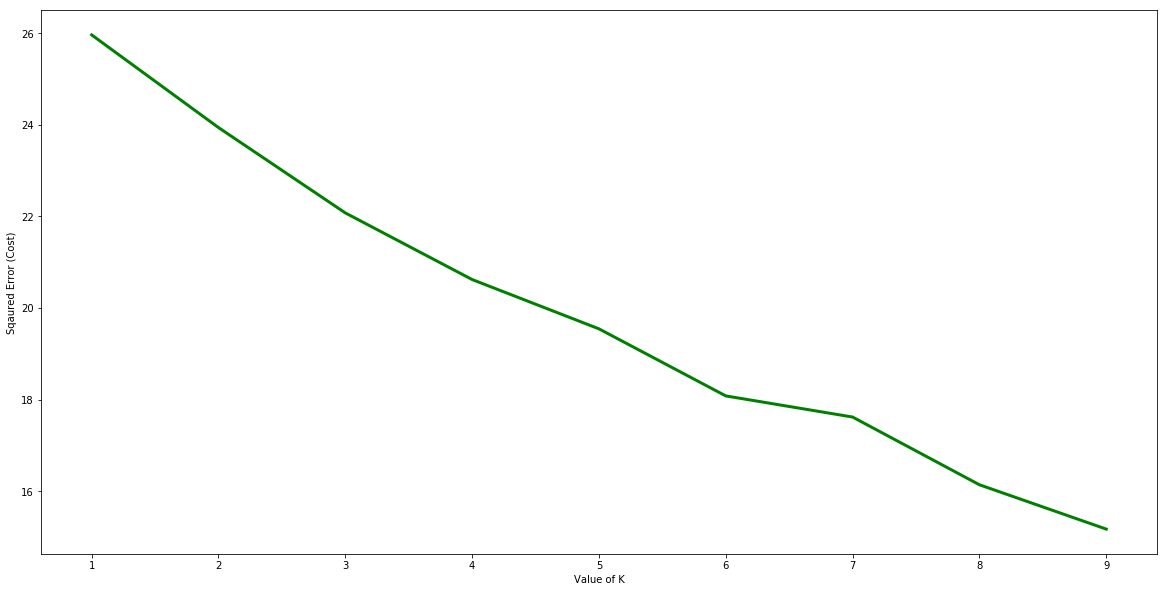

In [69]:
cost =[] 
for i in range(1, 10):
    KM = KMeans(n_clusters = i, max_iter = 350) 
    KM.fit(mumbai_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
plt.figure(figsize = (20,10))  
plt.plot(range(1, 10), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

### The issue with this data set is that the number of records is just too low, however we set the accepted error to be less than 20 for our application

## However at k = 6 we see sort of an elbow sop we go with k = 6


In [64]:
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 5, 5, 5, 5, 5, 5, 0, 5, 2])

In [65]:
mumbai_grouped_clustering.shape

(77, 120)

In [66]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
mumbai_merged = mumbai_df_final.copy()

# add clustering labels
mumbai_merged["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
mumbai_merged = mumbai_merged.join(area_venues_sorted.drop(["Location"], 1).set_index("Area"), on="Area")

print(mumbai_merged.shape)
mumbai_merged.head() # check the last columns!

(77, 15)


,Area,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,"Andheri,Western Suburbs",19.1293,72.8434,2,Asian Restaurant,Coffee Shop,Gym,Sandwich Place,Women's Store,French Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,5,Cocktail Bar,Café,Vegetarian / Vegan Restaurant,Asian Restaurant,Restaurant,Ice Cream Shop,Auto Workshop,Multiplex,Farmers Market,Food
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373,5,Chinese Restaurant,Electronics Store,Women's Store,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Farmers Market
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.82721,5,Smoke Shop,Women's Store,Fried Chicken Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store,Farmers Market
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.82927,5,Department Store,Gym / Fitness Center,Liquor Store,Women's Store,Fried Chicken Joint,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Electronics Store


In [67]:
mumbai_merged.sort_values(["Cluster Labels"], inplace=True)
print(mumbai_merged.shape)
mumbai_merged.head()

(77, 15)


,Area,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Dharavi,Mumbai,19.040208,72.85085,0,Fast Food Restaurant,Women's Store,Fried Chicken Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store,Farmers Market
34,Irla,"Vile Parle,Western Suburbs",19.108056,72.838056,0,Seafood Restaurant,Indian Restaurant,Paper / Office Supplies Store,Juice Bar,Smoke Shop,Miscellaneous Shop,Electronics Store,Café,Fast Food Restaurant,Food & Drink Shop
45,Indian Institute of Technology Bombay campus,"Powai,Eastern Suburbs",19.133636,72.915358,0,Concert Hall,Café,Snack Place,Women's Store,Fried Chicken Joint,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store
90,Dava Bazaar,South Mumbai,18.946882,72.831362,0,Indian Restaurant,Market,Cheese Shop,Fast Food Restaurant,Food Truck,Ice Cream Shop,Gym,Food & Drink Shop,Dance Studio,Deli / Bodega
50,Mankhurd,Harbour Suburbs,19.05,72.93,0,Sports Bar,Women's Store,Fried Chicken Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store,Farmers Market


## Visualising the clusters


In [68]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, area, location, cluster in zip(mumbai_merged['Latitude'], mumbai_merged['Longitude'], mumbai_merged['Area'], mumbai_merged['Location'], mumbai_merged['Cluster Labels']):
    label = folium.Popup('{} ({}): - Cluster {}'.format(area, location, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Analysing Clusters Individually

## Cluster 0


In [70]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 0, mumbai_merged.columns[[1] + list(range(5, mumbai_merged.shape[1]))]]


,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Mumbai,Fast Food Restaurant,Women's Store,Fried Chicken Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store,Farmers Market
34,"Vile Parle,Western Suburbs",Seafood Restaurant,Indian Restaurant,Paper / Office Supplies Store,Juice Bar,Smoke Shop,Miscellaneous Shop,Electronics Store,Café,Fast Food Restaurant,Food & Drink Shop
45,"Powai,Eastern Suburbs",Concert Hall,Café,Snack Place,Women's Store,Fried Chicken Joint,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store
90,South Mumbai,Indian Restaurant,Market,Cheese Shop,Fast Food Restaurant,Food Truck,Ice Cream Shop,Gym,Food & Drink Shop,Dance Studio,Deli / Bodega
50,Harbour Suburbs,Sports Bar,Women's Store,Fried Chicken Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store,Farmers Market
28,"Malad,Western Suburbs",Gym,Bakery,Women's Store,Fried Chicken Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store
55,South Mumbai,Café,Pizza Place,Snack Place,Indian Restaurant,Japanese Restaurant,Frozen Yogurt Shop,Other Great Outdoors,Coffee Shop,Chinese Restaurant,Salad Place
58,South Mumbai,Hotel,Wine Bar,Shoe Store,Café,Restaurant,Mediterranean Restaurant,Farmers Market,Food,Fast Food Restaurant,Electronics Store
65,South Mumbai,Indian Restaurant,Dessert Shop,Vegetarian / Vegan Restaurant,Coffee Shop,Café,Tea Room,Fast Food Restaurant,Men's Store,Cocktail Bar,Mediterranean Restaurant
66,South Mumbai,Bakery,Bar,Coffee Shop,Sandwich Place,Dessert Shop,Gift Shop,Salon / Barbershop,Pizza Place,Italian Restaurant,Arts & Crafts Store


### consist of mostly posh localities

## Cluster 1

In [71]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 1, mumbai_merged.columns[[1] + list(range(5, mumbai_merged.shape[1]))]]


,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Harbour Suburbs,Indian Restaurant,Diner,General Entertainment,Gastropub,French Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
89,"Tardeo,South Mumbai",Concert Hall,Park,Salon / Barbershop,Bookstore,Café,Chinese Restaurant,Restaurant,Fast Food Restaurant,Food,Electronics Store


### consist of mostly posh localities

## Cluster 2

In [72]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 2, mumbai_merged.columns[[1] + list(range(5, mumbai_merged.shape[1]))]]


,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,South Mumbai,Indian Restaurant,Bakery,Bar,Mexican Restaurant,Multiplex,Music Store,Coffee Shop,Chinese Restaurant,Café,Indie Movie Theater
59,South Mumbai,Bakery,Whisky Bar,Train Station,Plaza,Women's Store,Food & Drink Shop,Food,Fast Food Restaurant,Farmers Market,Electronics Store
77,South Mumbai,Ice Cream Shop,Lighthouse,Coffee Shop,Indian Restaurant,Harbor / Marina,Food Truck,Dance Studio,Deli / Bodega,Hotel Bar,Department Store
79,"Antop Hill,South Mumbai",Café,Ice Cream Shop,Liquor Store,Cajun / Creole Restaurant,Garden Center,Burrito Place,French Restaurant,Department Store,Dessert Shop,Diner
38,"Ghatkopar,Eastern Suburbs",Playground,Light Rail Station,French Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store
85,"Kalbadevi,South Mumbai",Fast Food Restaurant,Bus Station,Sandwich Place,Women's Store,French Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner
44,"Powai,Eastern Suburbs",Indian Restaurant,Fast Food Restaurant,Department Store,Arcade,Shopping Mall,Lounge,Cupcake Shop,Hotel,Coffee Shop,Clothing Store
64,South Mumbai,Indian Restaurant,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store,Farmers Market
0,"Andheri,Western Suburbs",Asian Restaurant,Coffee Shop,Gym,Sandwich Place,Women's Store,French Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner
11,"Mira-Bhayandar,Western Suburbs",Indian Restaurant,Juice Bar,Resort,Bus Station,Fried Chicken Joint,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store


## Cluster 3

In [73]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 3, mumbai_merged.columns[[1] + list(range(5, mumbai_merged.shape[1]))]]


,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,"Sanctacruz,Western Suburbs",Indian Restaurant,Light Rail Station,Lounge,Sandwich Place,Moving Target,Market,Middle Eastern Restaurant,Train Station,Platform,Dessert Shop
17,Western Suburbs,Train Station,Café,Women's Store,Fried Chicken Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store


## Cluster 4


In [74]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 4, mumbai_merged.columns[[1] + list(range(5, mumbai_merged.shape[1]))]]


,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,"Kandivali West,Western Suburbs",Coffee Shop,Fast Food Restaurant,Café,Women's Store,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store


## Cluster 5

In [75]:
mumbai_merged.loc[mumbai_merged['Cluster Labels'] == 5, mumbai_merged.columns[[1] + list(range(5, mumbai_merged.shape[1]))]]


,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,"Ghatkopar,Eastern Suburbs",Indian Restaurant,Ice Cream Shop,Italian Restaurant,Multiplex,Snack Place,Fast Food Restaurant,Food Truck,Food & Drink Shop,Food,Electronics Store
72,South Mumbai,Italian Restaurant,Train Station,Chinese Restaurant,Café,Women's Store,French Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner
73,South Mumbai,Train Station,Platform,Ice Cream Shop,Department Store,Restaurant,Fast Food Restaurant,Food Truck,Cupcake Shop,Dance Studio,Deli / Bodega
14,"Bandra,Western Suburbs",Bakery,Fast Food Restaurant,Indian Restaurant,Cupcake Shop,Dance Studio,Pizza Place,French Restaurant,Deli / Bodega,Department Store,Dessert Shop
12,"Bandra,Western Suburbs",Scenic Lookout,Hotel Bar,Chinese Restaurant,Boutique,Cocktail Bar,Beach,Café,Lounge,Gym,Italian Restaurant
6,"Andheri,Western Suburbs",Restaurant,Café,Women's Store,French Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store
5,"Andheri,Western Suburbs",Indian Restaurant,Auto Garage,Bakery,Snack Place,Bar,Women's Store,Fast Food Restaurant,French Restaurant,Food Truck,Food & Drink Shop
83,"Fort,South Mumbai",Harbor / Marina,Convenience Store,Hotel,French Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store
4,"Andheri,Western Suburbs",Department Store,Gym / Fitness Center,Liquor Store,Women's Store,Fried Chicken Joint,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Electronics Store
3,"Andheri,Western Suburbs",Smoke Shop,Women's Store,Fried Chicken Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Electronics Store,Farmers Market
